# Music Recommendation System

A content-based music recommendation system that suggests similar songs based on lyrics similarity using TF-IDF vectorization and FAISS (Facebook AI Similarity Search) for efficient nearest neighbor search.

---

## Table of Contents

1. [Environment Setup](#1-environment-setup)
2. [Import Libraries](#2-import-libraries)
3. [Data Collection](#3-data-collection)
4. [Data Exploration & Understanding](#4-data-exploration--understanding)
5. [Data Preprocessing](#5-data-preprocessing)
6. [Feature Engineering (TF-IDF)](#6-feature-engineering-tf-idf)
7. [Building FAISS Index](#7-building-faiss-index)
8. [Recommendation Function](#8-recommendation-function)
9. [Model Persistence](#9-model-persistence)

---

## 1. Environment Setup

First, we need to install all the required libraries for this project:

- **faiss-cpu**: Facebook AI Similarity Search for efficient similarity search
- **kaggle**: API to download datasets from Kaggle
- **numpy & pandas**: Data manipulation and numerical operations
- **matplotlib**: Data visualization
- **scikit-learn**: Machine learning utilities (TF-IDF, normalization)
- **wordcloud**: Visualizing word frequencies
- **nltk**: Natural Language Toolkit for text preprocessing


In [1]:
!pip install faiss-cpu kaggle numpy pandas matplotlib scikit-learn wordcloud nltk -q

## 2. Import Libraries

Importing all necessary libraries for:
- **File & Data Operations**: `os`, `json`, `numpy`, `pandas`
- **Text Processing**: `re`, `nltk` (stopwords, tokenization)
- **Machine Learning**: `sklearn` (TF-IDF, cosine similarity, normalization)
- **Visualization**: `matplotlib`, `wordcloud`
- **Vector Search**: `faiss` for efficient similarity search
- **Model Persistence**: `joblib` for saving/loading models

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import normalize
import faiss
import joblib

## 3. Data Collection

We're using the **Spotify Million Song Dataset** from Kaggle, which contains song lyrics along with artist and song information.

### 3.1 Configure Kaggle API

Load Kaggle credentials from `kaggle.json` file. You need to:
1. Create a Kaggle account
2. Go to Settings → API → Create New Token
3. Save the downloaded `kaggle.json` file in the project root

In [3]:
kaggle_config = json.load(open('kaggle.json'))
kaggle_config.keys()

dict_keys(['username', 'key'])

In [4]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

### 3.2 Download Dataset

Download the Spotify Million Song Dataset using Kaggle CLI. The dataset will be saved to the `./data` directory.


In [5]:
!kaggle datasets download notshrirang/spotify-million-song-dataset -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0




  0%|          | 0.00/20.7M [00:00<?, ?B/s]
100%|██████████| 20.7M/20.7M [00:00<00:00, 1.32GB/s]


### 3.3 Load Dataset

Load the downloaded CSV file into a pandas DataFrame for exploration and processing.

In [6]:
df = pd.read_csv('./data/spotify_millsongdata.csv')
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


## 4. Data Exploration & Understanding

Let's explore the dataset to understand its structure, size, and content quality.

### 4.1 Dataset Overview

Check the shape, data types, and basic statistics of our dataset.

In [7]:
print("Data shape: ", df.shape)
print("\nData info:")
df.info()

Data shape:  (57650, 4)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


### 4.2 Missing Values Check

Check for any missing values in the dataset that might need handling.

In [8]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

### 4.3 Top Artists Analysis

Identify the most frequently appearing artists in the dataset.

In [9]:
top_artists = df['artist'].value_counts().head(10)
print("Top 10 Artists:\n", top_artists)

Top 10 Artists:
 artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


### 4.4 Lyrics Word Cloud

Visualize the most common words in all song lyrics using a word cloud. This helps us understand the common themes and vocabulary in the dataset.

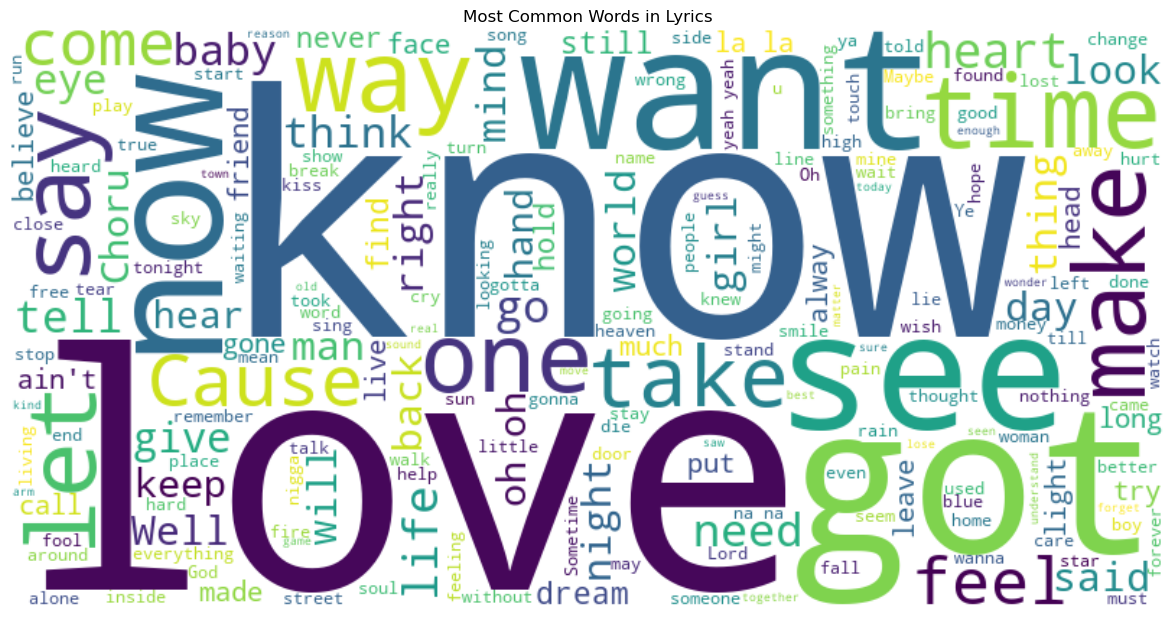

In [10]:
all_lyrics = ' '.join(df['text'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Lyrics')
plt.show()

## 5. Data Preprocessing

Text preprocessing is crucial for building an effective recommendation system. We need to clean and normalize the lyrics text.

### 5.1 Download NLTK Resources

Download the required NLTK data packages:
- **punkt**: Tokenizer models for splitting text into words
- **stopwords**: Common words (like "the", "is", "at") that we'll remove

In [11]:
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 5.2 Define Stopwords

Load the English stopwords list. These are common words that don't carry significant meaning for similarity comparison.

In [12]:
stop_words = set(stopwords.words('english'))

### 5.3 Text Preprocessing Function

Create a function to clean and normalize text:
1. **Remove special characters**: Keep only letters and spaces
2. **Convert to lowercase**: Normalize case
3. **Tokenize**: Split text into individual words
4. **Remove stopwords**: Filter out common words

In [13]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

### 5.4 Apply Preprocessing

Apply the preprocessing function to all song lyrics. This creates a new `cleaned_text` column with the processed lyrics.

In [14]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"Look at her face, it's a wonderful face \r\nA...",look face wonderful face means something speci...
1,"Take it easy with me, please \r\nTouch me gen...",take easy please touch gently like summer even...
2,I'll never know why I had to go \r\nWhy I had...,ill never know go put lousy rotten show boy to...
3,Making somebody happy is a question of give an...,making somebody happy question give take learn...
4,Making somebody happy is a question of give an...,making somebody happy question give take learn...


## 6. Feature Engineering (TF-IDF)

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical statistic that reflects how important a word is to a document in a collection.

- **Term Frequency (TF)**: How often a word appears in a document
- **Inverse Document Frequency (IDF)**: How rare a word is across all documents

Words that appear frequently in one song but rarely across all songs get higher weights, making them better for distinguishing between songs.

We limit to `max_features=5000` to keep the most important terms and reduce dimensionality.

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, dtype=np.float32)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Vocabulary Size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF Matrix Shape: (57650, 5000)
Vocabulary Size: 5000


## 7. Building FAISS Index

**FAISS (Facebook AI Similarity Search)** is a library for efficient similarity search and clustering of dense vectors.

### Why FAISS?
- Traditional cosine similarity has O(n) complexity for each query
- FAISS uses optimized algorithms for faster nearest neighbor search
- Essential for scaling to large datasets (millions of songs)

### Index Type: `IndexFlatIP`
- **IP** = Inner Product (equivalent to cosine similarity for L2-normalized vectors)
- **Flat** = Exact search (no approximation)
- We normalize vectors with L2 norm so inner product equals cosine similarity

In [16]:
X = tfidf_matrix.toarray()
X = normalize(X, norm="l2")

dim = X.shape[1]
print(f"Vector Dimension: {dim}")

index = faiss.IndexFlatIP(dim)
index.add(X)

print(f"Total vectors in FAISS index: {index.ntotal}")
print("FAISS index built successfully!")

Vector Dimension: 5000
Total vectors in FAISS index: 57650
FAISS index built successfully!


## 8. Recommendation Function

The core recommendation logic:

1. **Find the song**: Look up the input song name in our dataset
2. **Get its vector**: Retrieve the TF-IDF vector for that song
3. **Search similar songs**: Use FAISS to find the k most similar songs
4. **Return results**: Return song details (excluding the input song itself)

In [17]:
def recommend_songs(song_name, df=df, top_k=5):

    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]

    query = X[idx].reshape(1, -1)

    scores, indices = index.search(query, top_k + 1)

    return df[['song', 'artist']].iloc[indices[0][1:]]

### Test the Recommendation System

Let's test our recommendation system by getting similar songs for the first song in our dataset.

In [18]:
test_song = df['song'].iloc[0]
test_artist = df['artist'].iloc[0]
print(f"Getting recommendations for: '{test_song}' by {test_artist}")
print("-" * 50)

recommendations = recommend_songs(test_song)
display(recommendations)

Getting recommendations for: 'Ahe's My Kind Of Girl' by ABBA
--------------------------------------------------


,song,artist
44380,The Kind Of Girl I Could Love,The Monkees
26374,Could I,Bread
40719,She's So European,Kiss
14018,One Of These Things First,Nick Drake
11857,That Boy,Lloyd Cole


## 9. Model Persistence

Save the trained models and processed data for later use:

- **df_cleaned.pkl**: Preprocessed DataFrame with cleaned lyrics
- **faiss_index.pkl**: FAISS index for fast similarity search
- **tfidf_matrix.pkl**: TF-IDF vectors for all songs

These files can be loaded later to make recommendations without retraining.

In [19]:
joblib.dump(df, 'df_cleaned.pkl')
print("Saved: df_cleaned.pkl")

joblib.dump(index, 'faiss_index.pkl')
print("Saved: faiss_index.pkl")

joblib.dump(X, 'tfidf_matrix.pkl')
print("Saved: tfidf_matrix.pkl")

print("\nAll models saved successfully!")

Saved: df_cleaned.pkl
Saved: faiss_index.pkl
Saved: tfidf_matrix.pkl

All models saved successfully!


---

## Summary

### What We Built
A **content-based music recommendation system** that suggests similar songs based on lyrics analysis.

### Key Components
| Component | Technology | Purpose |
|-----------|------------|---------|
| Text Preprocessing | NLTK | Clean and normalize lyrics |
| Feature Extraction | TF-IDF | Convert text to numerical vectors |
| Similarity Search | FAISS | Fast nearest neighbor search |
| Persistence | Joblib | Save/load trained models |

### Performance
- **Dataset**: 57,650 songs from Spotify Million Song Dataset
- **Features**: 5,000 TF-IDF features per song
- **Search**: Near-instant similarity search using FAISS

### Future Improvements
- Add audio features (tempo, key, energy) for hybrid recommendations
- Implement user preference learning
- Deploy as a web application
- Add genre-based filtering
